# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Synthetic data generation

## Helper functions

In [ ]:
def plot_all_benchmark_scores(scores_df):
    """
    Plot all scores from all benchmarks on a single graph.
    Each benchmark's scores are plotted as scatter points connected by lines.
    """
    plt.figure(figsize=(10, 6))

    # Group by benchmark_id and plot each one
    for bench_id, group in scores_df.groupby("benchmark_id"):
        group = group.sort_values("date")
        plt.scatter(group["date"], group["performance"], alpha=0.6, label=f"Benchmark {bench_id}")
        plt.plot(group["date"], group["performance"], linestyle="--", alpha=0.6)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title("Performance on All Benchmarks Over Time")
    plt.grid(True)
    # plt.legend()
    plt.show()

def plot_benchmark_scores(benchmark_id, scores_df):
    """
    Plot scores on a specified benchmark over time.
    """
    bench_scores = scores_df[scores_df['benchmark_id'] == benchmark_id].copy()
    if bench_scores.empty:
        print(f"No scores available for benchmark_id {benchmark_id}.")
        return
    bench_scores.sort_values("model_times", inplace=True)

    plt.figure(figsize=(8, 5))
    plt.scatter(bench_scores['date'], bench_scores['performance'], color="blue", label="Scores", alpha=0.7)
    plt.plot(bench_scores['date'], bench_scores['performance'], linestyle="--", color="blue", alpha=0.7)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title(f"Performance on Benchmark {benchmark_id} Over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# -------------------------
# Data generation
# -------------------------

def generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.05,
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=3,
    max_alpha=10,
    frac_accelerate_models=1
):
    np.random.seed(42)

    # Models
    model_times = np.sort(
        np.random.uniform(time_range_start, time_range_end, num_models)
    )
    slope_model = elo_change / (time_range_end - time_range_start)

    # Decide which post-cutoff models accelerate
    random_draws     = np.random.rand(num_models)
    accelerate_mask  = (model_times >= cutoff_year) & (random_draws < frac_accelerate_models)

    # Compute capabilities
    model_capabilities = (
        base_model
        + np.where(
            accelerate_mask,
            # accelerated: baseline until cutoff, then faster slope
            slope_model * (cutoff_year - time_range_start) +
            speedup_factor_model * slope_model * (model_times - cutoff_year),
            # normal: same slope the whole time
            slope_model * (model_times - time_range_start)
        )
        + np.random.normal(0, noise_std_model, num_models)
    )
    models = pd.DataFrame({
        'model_id': np.arange(num_models),
        'date': model_times,
        'model_capabilities': model_capabilities,
        'accelerated': accelerate_mask
    })

    # Benchmarks
    benchmark_times = np.random.uniform(
        time_range_start, time_range_end, num_benchmarks
    )
    slope_bench = elo_change / (time_range_end - time_range_start)
    benchmark_difficulties = (
        base_bench
        + np.where(
            benchmark_times < cutoff_year,
            slope_bench * (benchmark_times - time_range_start),
            slope_bench * (cutoff_year - time_range_start)
              + 1 * slope_bench * (benchmark_times - cutoff_year)
        )
    )
    benchmark_progress_slopes = np.random.uniform(
        min_alpha, max_alpha, num_benchmarks
    )
    benchmarks = pd.DataFrame({
        'benchmark_id': np.arange(num_benchmarks),
        'benchmark_release_date': benchmark_times,
        'benchmark_difficulties': benchmark_difficulties,
        'benchmark_progress_slopes': benchmark_progress_slopes
    })

    def logistic(x):
        return 1 / (1 + np.exp(-x))

    # Scores
    scores = []
    for _, m in models.iterrows():
        raw = logistic(
            benchmarks['benchmark_progress_slopes']
            * (m['model_capabilities'] - benchmarks['benchmark_difficulties'])
        )
        mask = (raw >= saturation_level) & (raw <= 1 - saturation_level)
        for b_idx, s in zip(benchmarks['benchmark_id'][mask], raw[mask]):
            if np.random.rand() < frac_eval:
                noisy = np.clip(s + np.random.normal(0, error_std), 0, 1 - saturation_level)
                scores.append({
                    'model_id': m['model_id'],
                    'benchmark_id': b_idx,
                    'date': m['date'],
                    'performance': noisy
                })
    df_scores = pd.DataFrame(scores)

    return models, benchmarks, df_scores

In [ ]:
from scipy.optimize import least_squares

def estimated_capabilities(models, benchmarks, df):
  # -----------------------------
  # 1) Identify valid/invalid models
  # -----------------------------
  valid_model_ids = sorted(df["model_id"].unique())  # all models with data
  skipped_model_ids = set(models["model_id"]) - set(valid_model_ids)
  print("Skipping models (no data):", skipped_model_ids)

  # -----------------------------
  # 2) Create a mapping for valid models (without re-indexing original DataFrame)
  # -----------------------------
  # Map each valid model's original id to a parameter index for fitting.
  model_id_to_fit_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
  num_valid_models = len(valid_model_ids)
  num_benchmarks = benchmarks.shape[0]  # Assuming benchmark ids are 0, 1, ..., (num_benchmarks-1)

  # -----------------------------
  # 3) Prepare arrays for fitting
  # -----------------------------
  # Convert the model_ids in scores_df using the mapping (for valid models only)
  model_idx_for_data = np.array([model_id_to_fit_idx[m] for m in df["model_id"]])

  # Ensure benchmark_ids are integers
  benchmark_ids_for_data = df["benchmark_id"].values.astype(int)
  anchor_idx        = 0                       # first element of that array
  observed_scores = df["performance"].values

  # -----------------------------
  # 4) Define logistic and residual functions
  # -----------------------------
  def logistic(x):
      return 1 / (1 + np.exp(-x))

  def residuals(params, model_idx_for_data, benchmark_ids_for_data, observed_scores):
      # Unpack parameters
      C = params[:num_valid_models]  # capabilities for valid models
      D = params[num_valid_models:num_valid_models + num_benchmarks]  # benchmark difficulties
      alpha = params[num_valid_models + num_benchmarks:]  # benchmark slopes

      # Use the mapped indices
      c_vals = C[model_idx_for_data]
      d_vals = D[benchmark_ids_for_data]
      alpha_vals = alpha[benchmark_ids_for_data]

      # Compute predicted logistic scores
      preds = logistic(alpha_vals * (c_vals - d_vals))
      return preds - observed_scores

  # -----------------------------
  # 5) Set initial guesses
  # -----------------------------
  initial_C = np.zeros(num_valid_models)
  initial_D = np.zeros(num_benchmarks)
  initial_alpha = np.ones(num_benchmarks)
  initial_params = np.concatenate([initial_C, initial_D, initial_alpha])

  # -----------------------------
  # 6) Fit only the valid models
  # -----------------------------
  result = least_squares(
      residuals,
      initial_params,
      args=(model_idx_for_data, benchmark_ids_for_data, observed_scores)
  )

  estimated_params = result.x
  estimated_C = estimated_params[:num_valid_models]
  estimated_D = estimated_params[num_valid_models:num_valid_models + num_benchmarks]
  estimated_alpha = estimated_params[num_valid_models + num_benchmarks:]

  # -----------------------------
  # 7) Map the fitted capabilities back to the original model IDs (for valid models only)
  # -----------------------------
  # 7a) Build a DataFrame of unaligned C’s for each valid model_id:
  fitted_C_df = pd.DataFrame({
      "model_id": valid_model_ids,
      "unaligned_C": estimated_C
  })

  # 7b) Pull in the true capabilities and date from your original models DF:
  #     this automatically lines everything up by model_id
  meta = models[["model_id", "model_capabilities", "date"]]
  fitted_C_df = fitted_C_df.merge(meta, on="model_id", how="left")

  # 7c) Compute the alignment transform:
  a, b = np.polyfit(
      fitted_C_df["unaligned_C"].values,
      fitted_C_df["model_capabilities"].values,
      1
  )
  print(f"Alignment transform: C_aligned = {a:.3f} * C_fit + {b:.3f}")

  # 7d) Apply it to get your final estimated_capability:
  fitted_C_df["estimated_capability"] = (
      a * fitted_C_df["unaligned_C"] + b
  )

  # 7e) Drop any extra cols if you only want model_id, date, estimated_capability:
  return fitted_C_df #[["model_id", "date", "estimated_capability"]]

# Broad acceleration

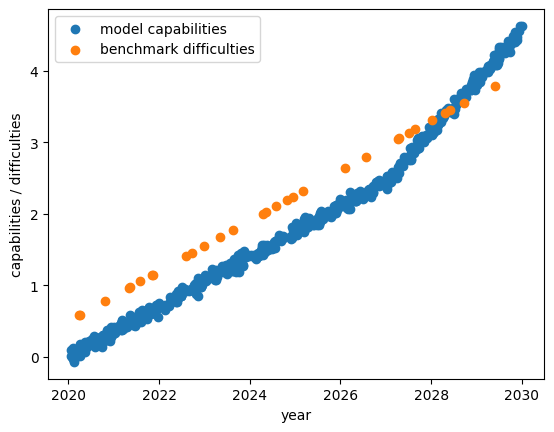

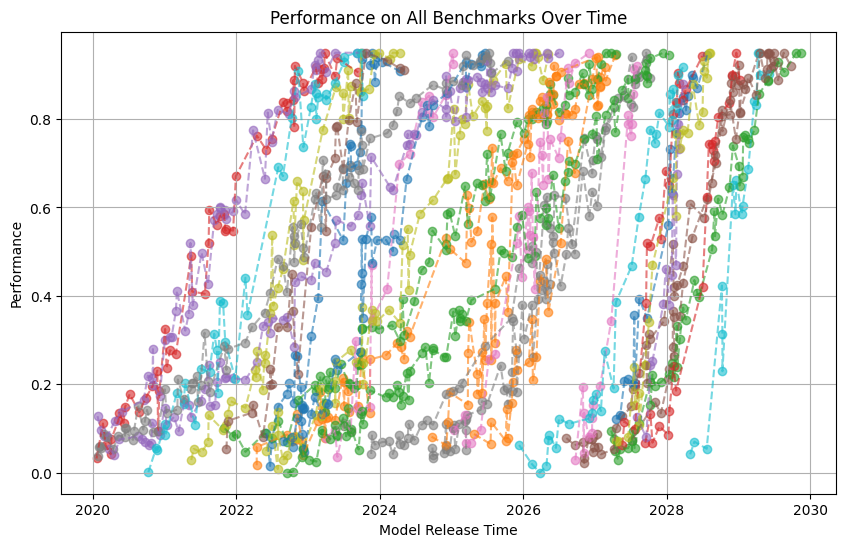

In [ ]:
models_broad, benchmarks_broad, df_broad = generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.05,
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=2.5,
    max_alpha=10,
    frac_accelerate_models=1
)

plt.scatter(models_broad["date"], models_broad["estimated_capability"], label="model capabilities")
plt.scatter(benchmarks_broad["benchmark_release_date"], benchmarks_broad["benchmark_difficulties"], label="benchmark difficulties")
plt.legend()
plt.xlabel("year")
plt.ylabel("capabilities / difficulties")
plt.show()

plot_all_benchmark_scores(df_broad)

In [ ]:
df_broad_est = estimated_capabilities(models_broad, benchmarks_broad, df_broad)
df_broad_est

Skipping models (no data): {0, 517, 7, 10, 14, 16, 529, 18, 530, 22, 534, 24, 537, 26, 27, 539, 540, 30, 542, 35, 36, 550, 39, 551, 41, 552, 49, 50, 563, 564, 565, 566, 567, 568, 569, 571, 60, 572, 573, 575, 64, 577, 578, 579, 68, 69, 70, 71, 580, 581, 582, 583, 584, 586, 78, 587, 80, 589, 590, 83, 591, 592, 594, 87, 595, 89, 596, 597, 598, 599, 106, 116, 122, 130, 132, 140, 265, 266, 279, 293, 320, 333, 338, 345, 363, 389, 394, 423, 464, 476, 500}
Alignment transform: C_aligned = 0.921 * C_fit + 1.941


,model_id,unaligned_C,model_capabilities,date,estimated_capability
0,1,-2.383843,0.016040,2020.055221,-0.254661
1,2,-2.073703,-0.003428,2020.069521,0.031017
2,3,-2.149419,0.126248,2020.091971,-0.038726
3,4,-2.136952,-0.034469,2020.108377,-0.027243
4,5,-2.123106,-0.070203,2020.113536,-0.014489
...,...,...,...,...,...
504,574,2.285845,4.247629,2029.626484,4.046724
505,576,2.330201,4.286831,2029.636200,4.087582
506,585,2.139243,4.267747,2029.730106,3.911685
507,588,2.526860,4.485901,2029.800326,4.268730


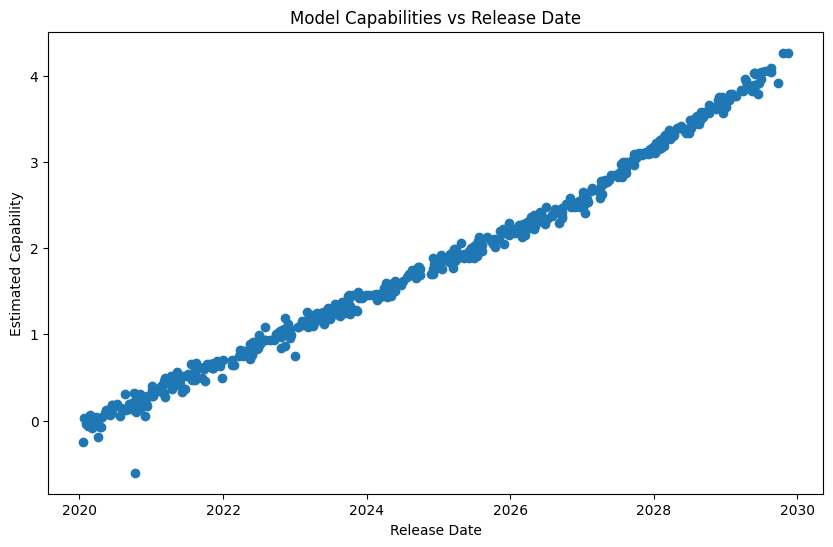

In [ ]:
# Simple scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_broad_est['date'], df_broad_est['estimated_capability'])
plt.xlabel('Release Date')
plt.ylabel('Estimated Capability')
plt.title('Model Capabilities vs Release Date')
plt.show()

# Detect acceleration?

In [ ]:
def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    # First segment: y = slope1 * x + intercept1 (for x < breakpoint)
    # Second segment: continuous at breakpoint with slope2
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear_improved(x, y, num_breaks=30):
    """Fit a breakpoint by scanning candidate bps and optimizing."""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]

# -------------------------
# Sweep & detection over time_range_end
# -------------------------

def fit_piecewise_and_detect(vm, cutoff_year, num_post_windows, min_post=0.1, threshold=2.0):
    results = []
    vm['time_since_start'] = vm['date'] - vm['date'].min()
    end_year = vm["date"].max()
    post_windows = np.linspace(min_post, end_year - cutoff_year, num_post_windows)
    for T in post_windows:
        df = vm[vm['date'] <= cutoff_year + T]
        x = df['time_since_start'].values
        y = df['model_capabilities'].values
        params, r2 = fit_piecewise_linear_improved(x, y)
        s1, _, s2, _ = params
        results.append({
            'T_after': T,
            'slope_pre': s1,
            'slope_post': s2,
            'slope_ratio': s2/s1,
            'r2': r2
        })
    res_df = pd.DataFrame(results)
    mask = res_df['slope_ratio'] >= threshold
    if mask.any():
        first = res_df[mask].iloc[0]
        detect = (first['T_after'], first['slope_ratio'])
    else:
        detect = (None, None)
    return res_df, detect

df_res, detect = fit_piecewise_and_detect(df_broad_est, cutoff_year=2027, num_post_windows=50, threshold=1.5)
print(detect)
df_res.head()

(np.float64(0.5520603046538985), np.float64(1.5776989186250265))


,T_after,slope_pre,slope_post,slope_ratio,r2
0,0.100000,0.366339,0.347987,0.949904,0.995235
1,0.156508,0.365227,0.348439,0.954036,0.995244
2,0.213015,0.365227,0.348439,0.954036,0.995244
3,0.269523,0.349050,0.380550,1.090244,0.995304
4,0.326030,0.348776,0.414418,1.188207,0.995362


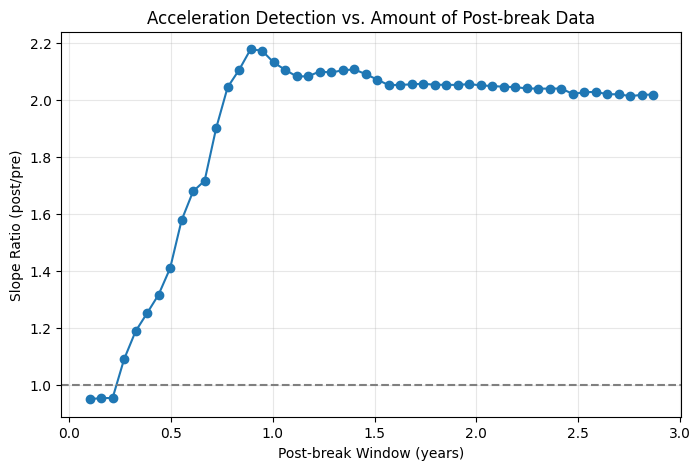

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_res['T_after'], df_res['slope_ratio'], marker='o')
plt.axhline(1, color='gray', linestyle='--')
plt.xlabel('Post-break Window (years)')
plt.ylabel('Slope Ratio (post/pre)')
plt.title('Acceleration Detection vs. Amount of Post-break Data')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
time_range_end = 2030
time_range_start = 2020
cutoff_year = 2027

num_models_list = np.array([40, 60, 80, 100, 120]) * (time_range_end - time_range_start) # e.g. 40/year
num_benchmarks_list = np.array([2, 4, 6, 8, 10]) * (time_range_end - time_range_start) # e.g. 2/year
acceleration_list = [2.5, 5]

num_post_windows = 50

records = []
for nm in num_models_list:
    for nb in num_benchmarks_list:
        for accel in acceleration_list:
            vm, _, _ = generate_data(
                num_models=nm,
                num_benchmarks=nb,
                speedup_factor_model=accel,
                time_range_start=time_range_start,
                time_range_end=time_range_end,
                cutoff_year=cutoff_year,
                frac_eval=0.25,
                error_std=0.025,
                elo_change=3.5,
                base_model=0,
                noise_std_model=0.05,
                base_bench=0.5,
                saturation_level=0.05,
                min_alpha=3,
                max_alpha=10,
                frac_accelerate_models=1
              )
            res_df, (T_det, ratio_det) = fit_piecewise_and_detect(
                vm, cutoff_year, num_post_windows
            )
            records.append({
                'models_per_year': int(nm / (time_range_end - time_range_start)),
                'benchmarks_per_year': int(nb / (time_range_end - time_range_start)),
                'actual_acceleration': accel,
                'detect_time': T_det,
                'est_acc_at_detect': ratio_det
            })

summary_df = pd.DataFrame(records)

In [ ]:
summary_df

,models_per_year,benchmarks_per_year,actual_acceleration,detect_time,est_acc_at_detect
0,40,2,2.5,0.615214,2.037103
1,40,2,5.0,0.328984,2.158794
2,40,4,2.5,0.615214,2.037103
3,40,4,5.0,0.328984,2.158794
4,40,6,2.5,0.615214,2.037103
5,40,6,5.0,0.328984,2.158794
6,40,8,2.5,0.615214,2.037103
7,40,8,5.0,0.328984,2.158794
8,40,10,2.5,0.615214,2.037103
9,40,10,5.0,0.328984,2.158794


In [ ]:
summary_df.to_csv("param_sweep_broad.csv")

In [ ]:
time_diff = (time_range_end - time_range_start)
models_per_year = num_models_list // time_diff
benchmarks_per_year = num_benchmarks_list // time_diff

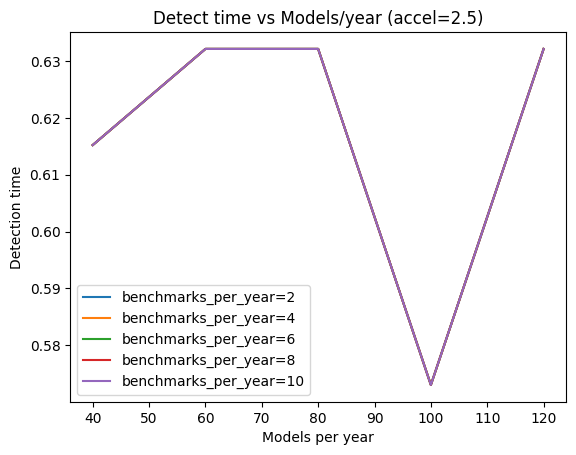

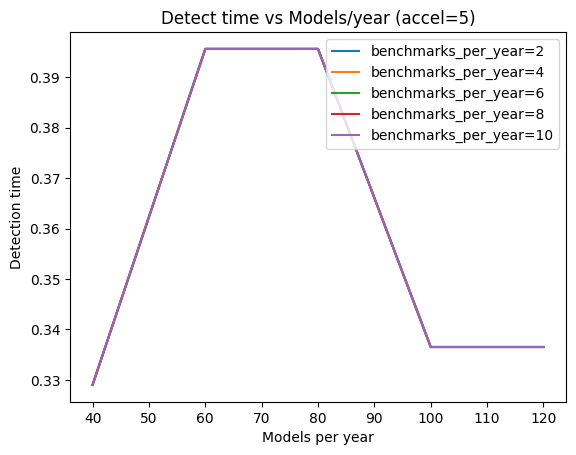

In [ ]:
# 1) Detection Time vs Models per Year
for acc in acceleration_list:
  plt.figure()
  for bt in benchmarks_per_year:
    df = summary_df[
        (summary_df['benchmarks_per_year'] == bt) &
        (summary_df['actual_acceleration'] == acc)
    ]
    plt.plot(df['models_per_year'], df['detect_time'], label=f"benchmarks_per_year={bt}")

  plt.xlabel("Models per year")
  plt.ylabel("Detection time")
  plt.title(f"Detect time vs Models/year (accel={acc})")
  plt.legend()
  plt.show()

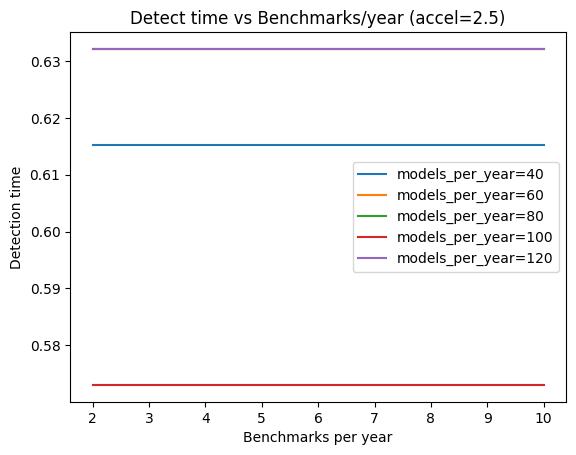

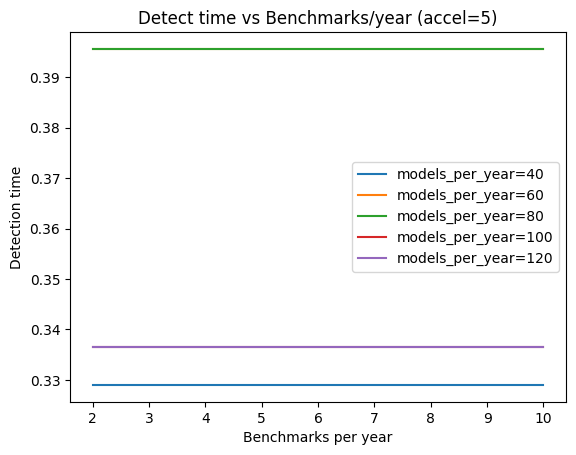

In [ ]:
# 2) Detection Time vs Benchmarks per Year
for acc in acceleration_list:
  plt.figure()
  for mt in models_per_year:
    df = summary_df[
        (summary_df['models_per_year'] == mt) &
        (summary_df['actual_acceleration'] == acc)
    ]
    plt.plot(df['benchmarks_per_year'], df['detect_time'], label=f"models_per_year={mt}")

  plt.xlabel("Benchmarks per year")
  plt.ylabel("Detection time")
  plt.title(f"Detect time vs Benchmarks/year (accel={acc})")
  plt.legend()
  plt.show()

# Narrow acceleration

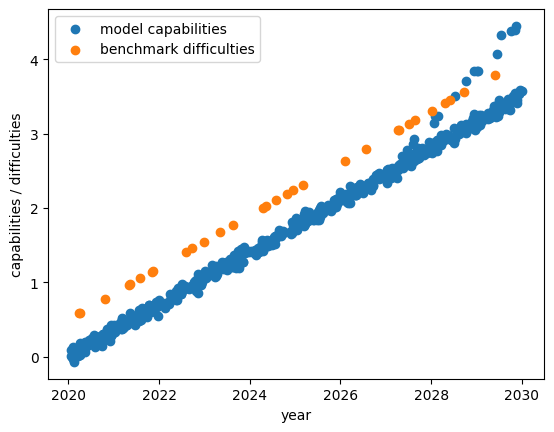

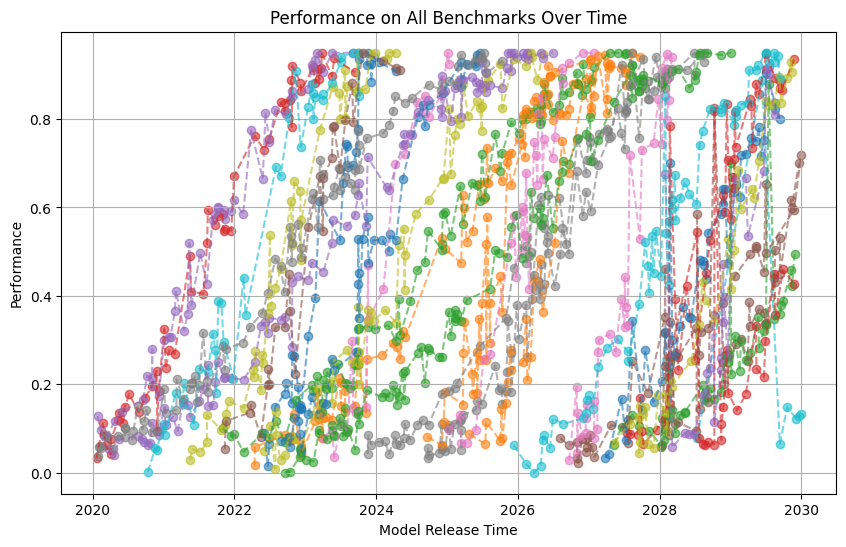

In [ ]:
models_broad, benchmarks_broad, df_broad = generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.05,
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=2.5,
    max_alpha=10,
    frac_accelerate_models=0.1
)

plt.scatter(models_broad["date"], models_broad["model_capabilities"], label="model capabilities")
plt.scatter(benchmarks_broad["benchmark_release_date"], benchmarks_broad["benchmark_difficulties"], label="benchmark difficulties")
plt.legend()
plt.xlabel("year")
plt.ylabel("capabilities / difficulties")
plt.show()

plot_all_benchmark_scores(df_broad)

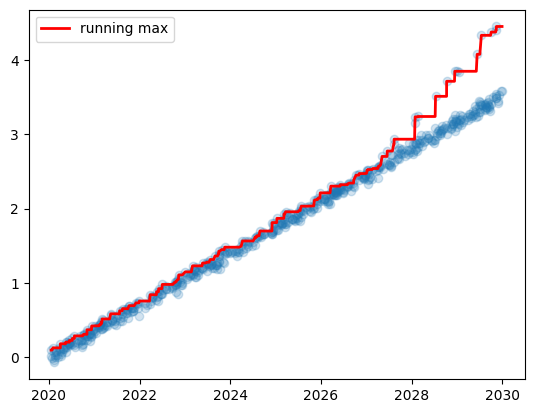

In [ ]:
df = models_broad.sort_values("date").copy()
df["running_max"] = df.model_capabilities.cummax()

plt.scatter(df.date, df.model_capabilities, alpha=0.2)
plt.plot(df.date, df.running_max, "r-", lw=2, label="running max")
plt.legend()
plt.show()

Breakpoint at year = 2027.231
Pre‐break slope = 0.347, post‐break slope = 0.711
R² = 0.9990


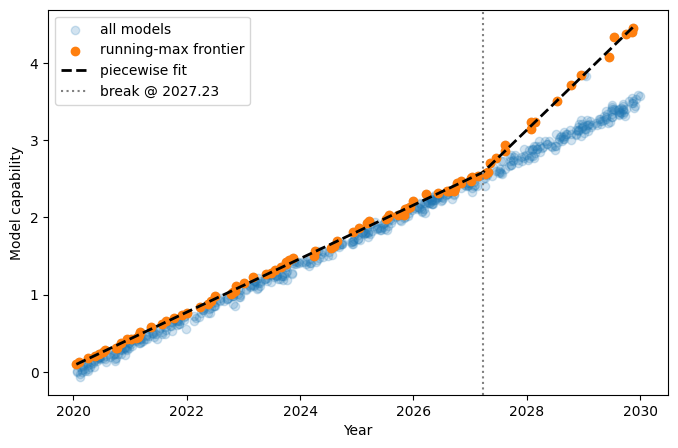

In [ ]:
# --- 1) compute running‐max frontier ---

df = models_broad.sort_values("date").copy()
df["running_max"] = df["model_capabilities"].cummax()

frontier_df = df[df["model_capabilities"] == df["running_max"]]

# x = float‐year, y = capability
x = frontier_df["date"].values
y = frontier_df["model_capabilities"].values

# --- 2) fit piecewise linear ---

params, best_r2 = fit_piecewise_linear_improved(x, y, num_breaks=50)
slope1, intercept1, slope2, bp = params

print(f"Breakpoint at year = {bp:.3f}")
print(f"Pre‐break slope = {slope1:.3f}, post‐break slope = {slope2:.3f}")
print(f"R² = {best_r2:.4f}")

# --- 3) plot everything ---

# dense x for smooth plot
x_fine = np.linspace(x.min(), x.max(), 400)
y_fine = piecewise_linear(x_fine, *params)

plt.figure(figsize=(8,5))
# all model points
plt.scatter(df["date"], df["model_capabilities"],
            alpha=0.2, label="all models")
# frontier points
plt.scatter(frontier_df["date"], frontier_df["model_capabilities"],
            color="C1", label="running‐max frontier")
# piecewise fit
plt.plot(x_fine, y_fine, "k--", lw=2, label="piecewise fit")
plt.axvline(bp, color="gray", linestyle=":", label=f"break @ {bp:.2f}")
plt.xlabel("Year")
plt.ylabel("Model capability")
plt.legend()
plt.show()